In [1]:
import numpy as np
import matplotlib.pyplot as plt

import io
import base64
from IPython import display

import gym
from gym import wrappers


class LanderAgent:
    def __init__(self, discritize_lander_state, augment_reward = None):
        self._q_table = {}

        self._discritize_lander_state = discritize_lander_state
        self._augment_reward = augment_reward
        if self._augment_reward is None:
            def reward_identity(reward, disc_state):
                return reward
            
            self._augment_reward = reward_identity

            
    def train(self, training_episodes = 1000, learning_rate = 0.1, discount_factor = 0.95, exploration_rate = 0.3, verbose = False):
        # initialize the first state
        environment = gym.make('LunarLander-v2')
        state = environment.reset()
        discrete_state = self._discritize_lander_state(state)
        self._q_table[discrete_state] = [0.0, 0.0, 0.0, 0.0]

        # Bookkeeping / debugging values
        avg_reward_per_episode = []
        rounds_per_episode = []
        
        for current_episode_num in range(training_episodes):
            state = environment.reset()
 
            discrete_state = self._discritize_lander_state(state)
            if self._q_table.get(discrete_state) is None:
                self._q_table[discrete_state] = [0.0, 0.0, 0.0, 0.0]

            # Bookkeeping / debugging values
            reward_accumulator = 0
            rounds_this_episode = 0
            
            # One while loop completion == one training episode
            # Also, don't let the agent play for more than 500 episodes.
            done = False
            while (not done) and (rounds_this_episode < 500):        
                # Exploit / Explore
                explore = np.random.random() < exploration_rate
                if explore:
                    action = environment.action_space.sample()
                else:
                    action = np.argmax(self._q_table[discrete_state])

                # Take the action, note we are discritizing again
                next_state, reward, done, _ = environment.step(action)
                discrete_next_state = self._discritize_lander_state(next_state)

                # If we've never seen this state before, make it.
                if self._q_table.get(discrete_next_state) is None:
                    self._q_table[discrete_next_state] = [0.0, 0.0, 0.0, 0.0]

                prev_q_value = self._q_table[discrete_state][action]
                discounted_future_reward = discount_factor * np.max(self._q_table[discrete_next_state])
                
                # This is where we apply our bonus reward!
                augmented_reward = self._augment_reward(reward, discrete_state)

                self._q_table[discrete_state][action] = (
                    prev_q_value + (learning_rate * (augmented_reward + discounted_future_reward - prev_q_value))
                )

                # Update the state for the next round. Note: discrete
                discrete_state = discrete_next_state
                
                # Bookkeeping / debugging
                reward_accumulator += reward
                rounds_this_episode += 1

            # Bookkeeping / debugging
            avg_reward_per_episode.append( reward_accumulator / rounds_this_episode )
            rounds_per_episode.append(rounds_this_episode)

            if verbose and (current_episode_num + 1) % 100 == 0:
                last_100_reward = np.average(avg_reward_per_episode[current_episode_num - 99: current_episode_num]) 
                last_100_rounds = np.average(rounds_per_episode[current_episode_num - 99: current_episode_num])

                print("Finished episode: ", current_episode_num)
                print("  Avg. Reward=", last_100_reward, "\n  Rounds per Episode: ", last_100_rounds, "\n")

        # Return useful history data for plotting performance.
        return avg_reward_per_episode, rounds_per_episode
    
    
    def embed_single_round(self):
        orig_environment = gym.make('LunarLander-v2')
        environment = wrappers.Monitor(orig_environment, "gym-videos/", force=True)

        # Lets visualize a single playthrough.
        state = environment.reset()
        discrete_state = self._discritize_lander_state(state)

        rounds = 0
        reward_sum = 0
        
        done = False
        while not done:
            action = np.argmax(self._q_table.get(discrete_state))
            state, reward, done, _ = environment.step(action)
            discrete_state = self._discritize_lander_state(state)
            
            reward_sum += reward
            rounds += 1

            # If the game finished before our max number of rounds, break out
            if done: break

        print("Final Reward: ", reward, "Round Avg. Reward: ", reward_sum / rounds)

        orig_environment.close()
        environment.close()

        
        video = io.open('./gym-videos/openaigym.video.%s.video000000.mp4' % environment.file_infix, 'r+b').read()
        encoded = base64.b64encode(video)
        embed = display.HTML(data='''
            <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
        .format(encoded.decode('ascii')))
        
        display.display(embed)

In [2]:
def train_and_display(lunar_agent, training_episodes, learning_rate = 0.1, discount_factor = 0.95, exploration_rate = 0.3, verbose = False, embeds = 0):
    reward_history, rounds_history = lunar_agent.train(
        training_episodes = training_episodes, 
        learning_rate = learning_rate,
        discount_factor = discount_factor,
        exploration_rate = exploration_rate,
        verbose = verbose
    )

    plt.plot(reward_history)
    plt.ylabel('avg. reward')
    plt.show()

    plt.plot(rounds_history)
    plt.ylabel('rounds')
    plt.show()
    
    for _ in range(embeds):
        lunar_agent.embed_single_round()
    
    return lunar_agent

In [3]:
def discritize_lander_state_four_buckets(lander_state):
    discritization_bins = np.array([-.05, 0, .05])
    discritized_vars = np.digitize(lander_state[0:6], discritization_bins)
    
    # For readability only, this likely degrades performance
    xpos, ypos, xvel, yvel, angle, angle_vel = discritized_vars
    
    # Return a tuple with the discritized vars, and the grounded/not grounded vars
    return (xpos, ypos, xvel, yvel, angle, angle_vel, lander_state[6], lander_state[7])

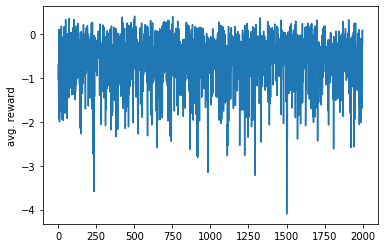

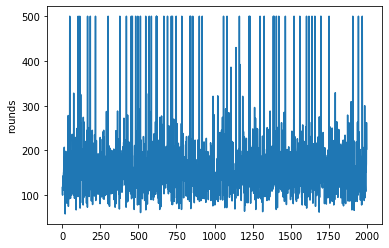

Final Reward:  -100 Round Avg. Reward:  -7.242558653631451


Final Reward:  -100 Round Avg. Reward:  0.04538870811303818


Final Reward:  -100 Round Avg. Reward:  -4.876568293194456


Final Reward:  -100 Round Avg. Reward:  -6.716465104685673


Final Reward:  -100 Round Avg. Reward:  -0.9481858863255243


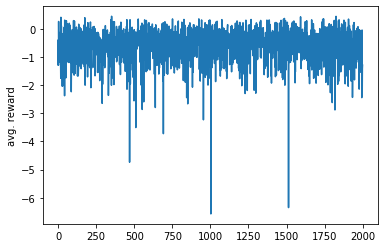

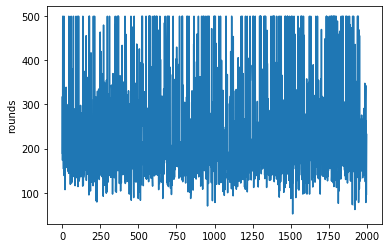

Final Reward:  -100 Round Avg. Reward:  -8.535497930755078


Final Reward:  -100 Round Avg. Reward:  -0.37202491803937837


Final Reward:  -100 Round Avg. Reward:  -1.6434823753245684


Final Reward:  -100 Round Avg. Reward:  -1.8516705310604658


Final Reward:  -100 Round Avg. Reward:  -1.5632131747878864


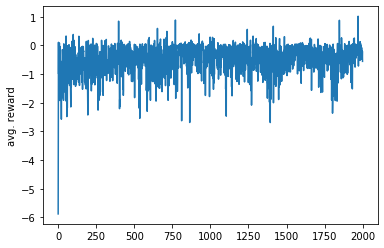

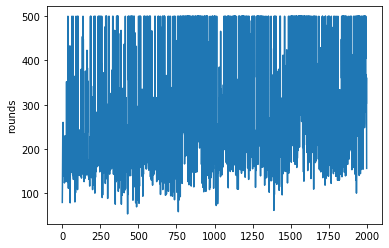

Final Reward:  -100 Round Avg. Reward:  -0.5520807574587399


Final Reward:  -100 Round Avg. Reward:  -0.07604687720680199


Final Reward:  -100 Round Avg. Reward:  -0.3236186159877166


Final Reward:  -100 Round Avg. Reward:  -0.03890557152620216


Final Reward:  -100 Round Avg. Reward:  -0.20903776860380413


In [4]:
four_state_agent = LanderAgent(
    discritize_lander_state_four_buckets,
    augment_reward = None
)

train_and_display(four_state_agent, 2000,
    learning_rate = 0.5,
    discount_factor = 0.80,
    exploration_rate = 0.5,
    embeds = 5,
    verbose = False
)

# Then, slow down learning, value future states more, explore a bit less
train_and_display(four_state_agent, 2000,
    learning_rate = 0.3,
    discount_factor = 0.90,
    exploration_rate = 0.3,
    embeds = 5,
    verbose = False
)

# Slow learning further, value future states even more, explore even less
train_and_display(four_state_agent, 2000,
    learning_rate = 0.1,
    discount_factor = 0.95,
    exploration_rate = 0.1,
    embeds = 5,
    verbose = False
)

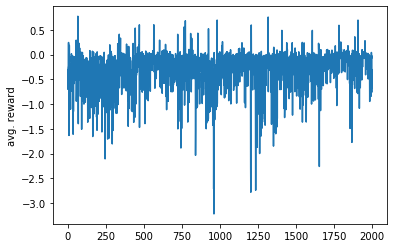

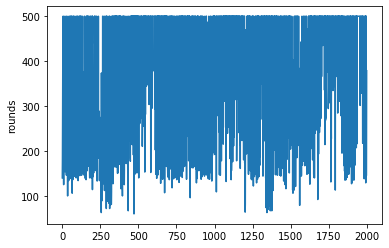

Final Reward:  -100 Round Avg. Reward:  -0.25721244962168516


Final Reward:  -100 Round Avg. Reward:  -0.8674549725317264


Final Reward:  -100 Round Avg. Reward:  -8.087436779738155


Final Reward:  -100 Round Avg. Reward:  -0.6390141481627208


Final Reward:  -100 Round Avg. Reward:  -0.9269603467278844


In [5]:
# Slow learning further, value future states even more, explore even less
train_and_display(four_state_agent, 2000,
    learning_rate = 0.08,
    discount_factor = 0.95,
    exploration_rate = 0.05,
    embeds = 5,
    verbose = False
)

In [6]:
# That discritization scheme learned enough to not just randomly die all the time
# ... yay ...
# I want the agent to have MORE information about the current height. 
# and I want to reward it for getting lower. 
def discritize_lander_state_four_buckets_and_height(lander_state):
    discritization_bins = np.array([-.05, 0, .05])
    discritized_vars = np.digitize(lander_state[0:6], discritization_bins)
    
    # For readability only, this likely degrades performance
    xpos, _, xvel, yvel, angle, angle_vel = discritized_vars
    
    discritization_y_pos = np.array([0, 0.01, 0.05, 0.1, 0.5, 0.8])
    ypos = np.digitize(lander_state[1], discritization_y_pos)
    
    # Return a tuple with the discritized vars, and the grounded/not grounded vars
    return (xpos, ypos, xvel, yvel, angle, angle_vel, lander_state[6], lander_state[7])


# As the lander gets lower, if the x values are in the "good" zone
# improve the reward
def reward_getting_lower(reward, discrete_state):
    xpos, ypos, xvel, yvel, _, _, _, _ = discrete_state

    # Essentially, extra punishment for rounds where you stay high.
    bonus_reward =+ (-1 * ypos)
    
    # Goal: reward for being very near the landing zone
    if xpos >= 1 and xpos <=2 and yvel == 1 and ypos <= 3:
        bonus_reward += 10 - ypos # WOW, BIG. Significant.
        
    return bonus_reward + reward

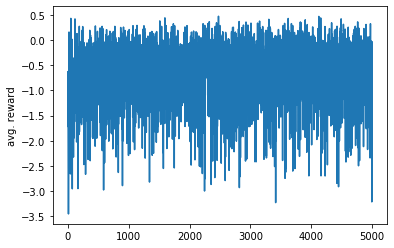

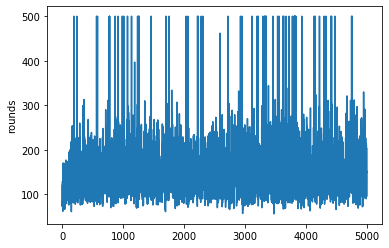

Final Reward:  -100 Round Avg. Reward:  -0.8118490335759577


Final Reward:  -100 Round Avg. Reward:  -0.27541995162539584


Final Reward:  -100 Round Avg. Reward:  -1.4496161112293786


Final Reward:  -100 Round Avg. Reward:  0.1989944871669789


Final Reward:  -100 Round Avg. Reward:  -0.7662681678015199


In [7]:
height_sensitive_agent = LanderAgent(
    discritize_lander_state_four_buckets_and_height,
    augment_reward = reward_getting_lower
)

train_and_display(height_sensitive_agent, 5000,
    learning_rate = 0.5,
    discount_factor = 0.80,
    exploration_rate = 0.5,
    embeds = 5
)


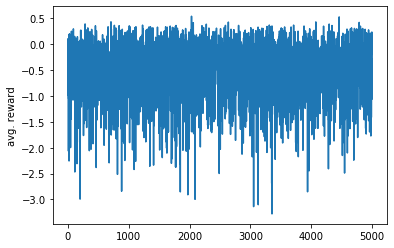

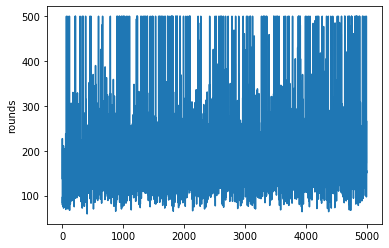

Final Reward:  -100 Round Avg. Reward:  -4.158969492953657


Final Reward:  -100 Round Avg. Reward:  -0.9023358198366265


Final Reward:  -100 Round Avg. Reward:  -1.5485363523850153


Final Reward:  -100 Round Avg. Reward:  -1.7174903695812482


Final Reward:  -100 Round Avg. Reward:  -2.1101851599396206


In [8]:
train_and_display(height_sensitive_agent, 5000,
    learning_rate = 0.3,
    discount_factor = 0.95,
    exploration_rate = 0.3,
    embeds = 5
)


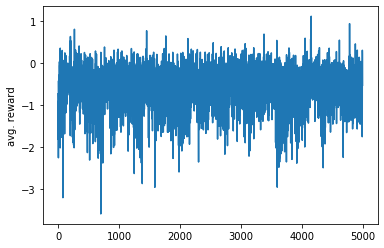

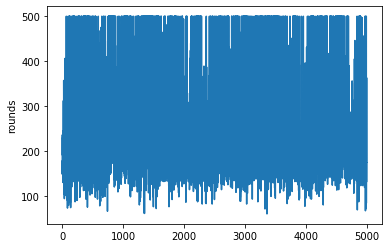

Final Reward:  -100 Round Avg. Reward:  -0.6292470829864532


Final Reward:  -100 Round Avg. Reward:  0.050163250027004315


Final Reward:  -100 Round Avg. Reward:  -0.6646840326884812


Final Reward:  -100 Round Avg. Reward:  -0.37639349750079815


Final Reward:  -100 Round Avg. Reward:  -0.9065483193371544


In [9]:
train_and_display(height_sensitive_agent, 5000,
    learning_rate = 0.1,
    discount_factor = 0.95,
    exploration_rate = 0.1,
    embeds = 5
)

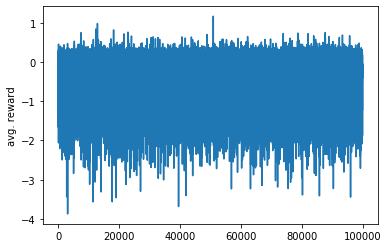

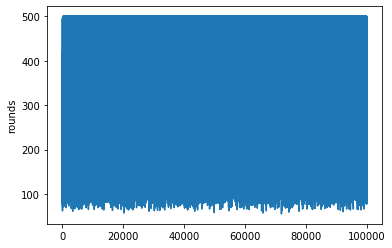

Final Reward:  -100 Round Avg. Reward:  -2.781935697834895


IndexError: list index out of range

In [10]:
train_and_display(height_sensitive_agent, 100000,
    learning_rate = 0.1,
    discount_factor = 0.95,
    exploration_rate = 0.3,
    embeds = 5
)


In [ ]:
# In this version of the state discritization, everything is "too much" "just right" or "too little"
# Values were chosen based on the careful evaluation of the lander game itself.
# AKA, this is at least partially an "expert system"
def discritize_lander_state_goldilocks(lander_state):
    discritization_bins_x_position = np.array([-.1, .1])   # Lander centered at 0
    discritization_bins_y_position = np.array([-.001, .1]) # Below lander AT ALL is bad. Above by much is also bad.
    discritization_bins_x_velocity = np.array([-.1, .1])   # moving left and right
    discritization_bins_y_velocity = np.array([-.15, -.01])  # moving up and down 
    discritization_bins_angle = np.array([-.03, .03])         # tilt / angle
    discritization_bins_angular_vel = np.array([-.05, .05]) # Angular vel
    
    # And discritize them separately.
    xpos = np.digitize(lander_state[0], discritization_bins_x_position)
    ypos = np.digitize(lander_state[1], discritization_bins_y_position)
    xvel = np.digitize(lander_state[2], discritization_bins_x_velocity)
    yvel = np.digitize(lander_state[3], discritization_bins_y_velocity)
    angle = np.digitize(lander_state[4], discritization_bins_angle)
    angle_vel = np.digitize(lander_state[5], discritization_bins_angular_vel)
    
    # Return a tuple with the discritized vars, and the grounded/not grounded vars
    return (xpos, ypos, xvel, yvel, angle, angle_vel, lander_state[6], lander_state[7])

# Get an extra reward if everything is "just right"
def reward_goldilocks(reward, discrete_state):
    bonus_reward = 5
    
    xpos, ypos, xvel, yvel, angle, angle_vel, left_grounded, right_grounded = discrete_state
    
    for state_value in [xpos, ypos, xvel, yvel, angle, angle_vel]:
        if state_value != 1:
            bonus_reward = 0
            break
        
    return bonus_reward + reward

In [ ]:
goldilocks_agent = LanderAgent(
    discritize_lander_state_goldilocks,
    augment_reward = reward_goldilocks
)

train_and_display(goldilocks_agent, 2000,
    learning_rate = 0.5,
    discount_factor = 0.80,
    exploration_rate = 0.5,
    embeds = 5
)

In [ ]:
# Lets train some more, again with a slower learning rate, less exp, and higher discount
train_and_display(goldilocks_agent, 2000,
    learning_rate = 0.3,
    discount_factor = 0.90,
    exploration_rate = 0.3,
    embeds = 5
)

In [ ]:
# That actually is looking kinda good!
train_and_display(goldilocks_agent, 2000,
    learning_rate = 0.15,
    discount_factor = 0.95,
    exploration_rate = 0.1,
    embeds = 5,
    verbose = False
)